# 1. Library Imports


In this section, we import all the necessary libraries for data preprocessing, tokenization, model training, and evaluation.


In [1]:
from typing import Dict, List, Optional, Tuple
import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EvalPrediction,
    BertConfig,
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from sklearn.model_selection import train_test_split

from torchsummary import summary
import yaml
import pandas as pd

from sklearn.metrics import f1_score, precision_score, recall_score

from pathlib import Path
import time

import os

# Creation Dataset

In [2]:
class AbstractsDataset(Dataset):
    """
    PyTorch Dataset for abstracts classification.

    Args:
        texts (List[str]): List of raw abstract texts.
        labels (Optional[List[int]]): List of integer labels. Optional for inference.
        tokenizer (BertTokenizerFast): Pretrained tokenizer.
        max_length (int): Max token length for padding/truncation.

    Returns:
        Dict[str, torch.Tensor]: Tokenized inputs and labels (if given).
    """

    def __init__(
        self,
        texts: List[str],
        labels: Optional[List[int]],
        tokenizer: BertTokenizerFast,
        max_length: int = 512,
    ):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt",
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item



In [3]:
import torch
import torch.nn as nn
from transformers import BertModel, BertPreTrainedModel

class BertForSequenceClassificationTwoLayer(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        
        self.bert = BertModel(config)  # backbone BERT
        
        # Layer nascosto: 768 (BERT hidden size) -> 1024 + ReLU
        self.hidden = nn.Linear(config.hidden_size, 1024)
        self.relu = nn.ReLU()
        
        # Layer di output: 1024 -> num_labels (classi)
        self.classifier = nn.Linear(1024, config.num_labels)
        
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
        self.init_weights()  # inizializza i pesi

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        pooled_output = outputs.pooler_output  # (batch_size, hidden_size=768)
        x = self.hidden(pooled_output)         # (batch_size, 1024)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.classifier(x)             # (batch_size, num_labels)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return {"loss": loss, "logits": logits}


In [4]:
class BertClassifier:
    """
    Wrapper for BERT fine-tuning on text classification using HuggingFace Trainer.

    Args:
        model_name (str): Name of pretrained BERT model.
        num_labels (int): Number of output classes.
        device (torch.device): Device to run model on.
    """

    def __init__(self, model_name: str, num_labels: int, device: torch.device, freeze_bert: bool = False, use_custom_head: bool = False,
                label2id: Optional[Dict[str, int]] = None,
                id2label: Optional[Dict[int, str]] = None,):
        self.device = device
        self.model_name = model_name
        self.num_labels = num_labels
        self.tokenizer = BertTokenizerFast.from_pretrained(model_name)
        if use_custom_head:
            # Custom model with head at 2 layers
            config = BertConfig.from_pretrained(model_name, num_labels=num_labels)
            self.model = BertForSequenceClassificationTwoLayer.from_pretrained(
                model_name, config=config,
                label2id=label2id if label2id else None,
                id2label=id2label if id2label else None
            ).to(device)
        else:
            # Classifcagtion standard of HuggingFace
            self.model = BertForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels,
                label2id=label2id if label2id else None,
                id2label=id2label if id2label else None
            ).to(device)
        self.trainer: Optional[Trainer] = None
        self.training_history: Dict[str, List[float]] = {}
        if freeze_bert:
            for param in self.model.bert.parameters():
                param.requires_grad = False
        

    def compute_metrics(self, p: EvalPrediction) -> Dict[str, float]:
        """
        Compute accuracy metric for evaluation.

        Args:
            p (EvalPrediction): HuggingFace prediction object with logits and labels.

        Returns:
            Dict[str, float]: Dictionary with accuracy.
        """
        preds = np.argmax(p.predictions, axis=1)
        return {
            "accuracy": accuracy_score(p.label_ids, preds),
            "f1": f1_score(p.label_ids, preds, average="weighted"),
            "precision": precision_score(p.label_ids, preds, average="weighted"),
            "recall": recall_score(p.label_ids, preds, average="weighted"),
        }

    def train(
        self,
        train_dataset: Dataset,
        val_dataset: Dataset,
        output_dir: str,
        epochs: int = 3,
        batch_size: int = 16,
        learning_rate: float = 5e-5,
        weight_decay: float = 0.01,
        save_checkpoints: bool = True,
    ) -> None:
        """
        Fine-tune BERT model on training dataset with validation.

        Args:
            train_dataset (Dataset): Training dataset.
            val_dataset (Dataset): Validation dataset.
            output_dir (str): Directory to save checkpoints.
            epochs (int): Number of epochs.
            batch_size (int): Batch size.
            learning_rate (float): Learning rate.
            weight_decay (float): Weight decay for optimizer.
        """

        #save_strategy = "steps" if save_checkpoints else "no"

        training_args = TrainingArguments(
            output_dir="checkpoints/",
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            eval_strategy="steps",
            eval_steps=200,
            save_strategy="steps",
            save_steps=400,
            learning_rate=3e-5,
            weight_decay=0.01,
            logging_dir="logs/",
            logging_steps=100,
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            greater_is_better=True,
            save_total_limit=2,
            seed=42,
            report_to="none",
            gradient_checkpointing=True,
            gradient_checkpointing_kwargs={"use_reentrant": False},
        )


        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=self.compute_metrics,
        )
        train_result = self.trainer.train()
        self.training_history = self.trainer.state.log_history

    def evaluate(self, dataset: Dataset) -> Dict[str, float]:
        """
        Evaluate model on given dataset.

        Args:
            dataset (Dataset): Dataset to evaluate on.

        Returns:
            Dict[str, float]: Evaluation metrics including loss and accuracy.
        """
        assert self.trainer is not None, "Trainer not initialized, train first."
        metrics = self.trainer.evaluate(eval_dataset=dataset)
        return metrics

    def predict(self, texts: List[str], max_length: int = 512) -> List[int]:
        """
        Run inference on raw texts, returning predicted class indices.

        Args:
            texts (List[str]): List of raw texts to classify.
            max_length (int): Max token length for tokenizer.

        Returns:
            List[int]: Predicted class indices.
        """
        encodings = self.tokenizer(
            texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt"
        )
        input_ids = encodings["input_ids"].to(self.device)
        attention_mask = encodings["attention_mask"].to(self.device)

        self.model.eval()
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)
        return preds.cpu().tolist()

    def print_model_summary(self, batch_size: int = 1, sequence_length: int = 512) -> None:
        """
        Stampa un riepilogo del modello simile a model.summary() in Keras.
    
        Args:
            batch_size (int): Dimensione batch da usare per la simulazione.
            sequence_length (int): Lunghezza massima della sequenza di input.
        """
        summary(self.model, input_size=(batch_size, sequence_length), col_names=["input_size", "output_size", "num_params", "trainable"])

    def plot_losses(self, plot_path: str) -> None:
        """
        Plot training and validation losses over steps.
        """
        if not self.training_history:
            raise ValueError("No training history found. Train the model first.")

        train_steps, train_losses = [], []
        val_steps, val_losses = [], []

        for record in self.training_history:
            if "loss" in record and "step" in record:
                train_steps.append(record["step"])
                train_losses.append(record["loss"])
            if "eval_loss" in record and "step" in record:
                val_steps.append(record["step"])
                val_losses.append(record["eval_loss"])

        plt.figure(figsize=(10, 6))
        plt.plot(train_steps, train_losses, marker="o", linestyle="-", color="tab:blue", label="Training Loss")
        if val_losses:
            plt.plot(val_steps, val_losses, marker="x", linestyle="--", color="tab:orange", label="Validation Loss")

        plt.xlabel("Step", fontsize=12)
        plt.ylabel("Loss", fontsize=12)
        #plt.title("Training and Validation Loss per Step", fontsize=14)
        plt.legend(fontsize=11)
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.savefig(plot_path, dpi=300, bbox_inches="tight")
        plt.show()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../Models/scibert_scivocab_uncased/scibert_scivocab_uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
200,1.913400,1.677769,0.562326,0.519203,0.549596,0.562326
400,1.516700,1.431007,0.601093,0.578773,0.593582,0.601093
600,1.443900,1.366542,0.615424,0.595200,0.606642,0.615424
800,1.310200,1.324605,0.618311,0.598263,0.614805,0.618311
1000,1.269000,1.270358,0.639860,0.624293,0.629436,0.639860
1200,1.249500,1.248300,0.631508,0.616701,0.632896,0.631508
1400,1.234100,1.208181,0.636973,0.626419,0.637877,0.636973
1600,1.141500,1.209600,0.649552,0.634348,0.640762,0.649552
1800,1.138800,1.196608,0.641509,0.627910,0.638724,0.641509
2000,1.119400,1.132665,0.658006,0.646173,0.655819,0.658006


/home/carmine-landolfi/miniconda3/envs/d2l/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carmine-landolfi/miniconda3/envs/d2l/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carmine-landolfi/miniconda3/envs/d2l/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

/home/carmine-landolfi/miniconda3/envs/d2l/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation metrics: {'eval_loss': 1.1141051054000854, 'eval_accuracy': 0.6785235591298072, 'eval_f1': 0.6737369336346801, 'eval_precision': 0.6736287721570408, 'eval_recall': 0.6785235591298072, 'eval_runtime': 231.3476, 'eval_samples_per_second': 41.924, 'eval_steps_per_second': 2.624, 'epoch': 3.0}


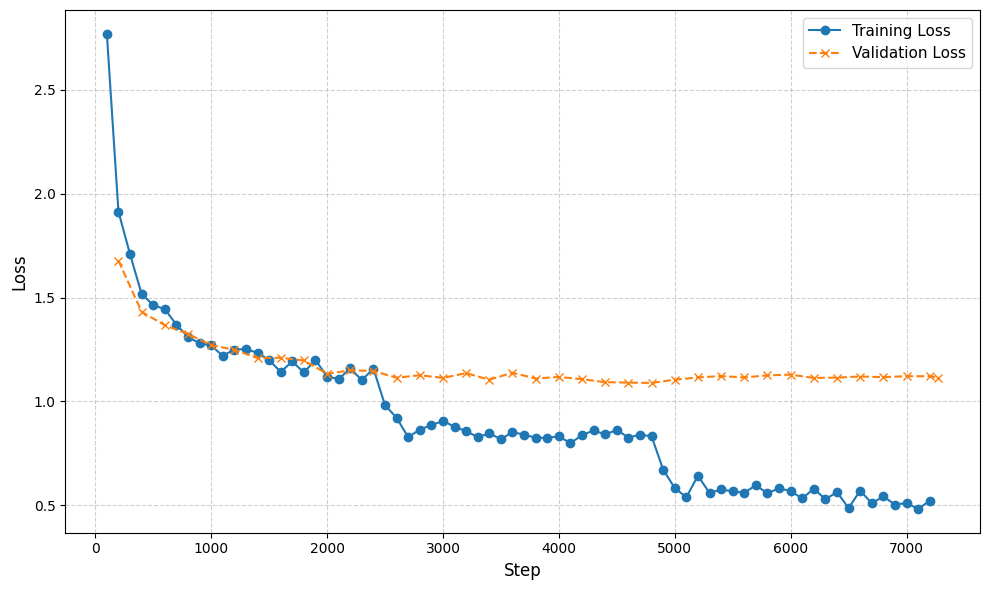

Model e tokenizer saved in ../Models/Fine_tuned_SciBERT
Execution time: 338.77 minutes


In [5]:
# Start timer
start_time = time.time()

def load_yaml(path):
    with open(path, "r") as f:
        return yaml.safe_load(f)
config = load_yaml("../File_Yaml/Esecuzione_Fine_Tuning_SciBERT.yaml")

# Leggi dataset csv
df = pd.read_csv(config["data_path"])
texts = df["abstract_clean"].tolist()

unique_classes = sorted(set(df["primary_category"]))
class_to_int = {label : i for i , label in enumerate(unique_classes)}
int_to_class = {i: label for label, i in class_to_int.items()}

labels = np.array([class_to_int[label] for label in df["primary_category"]])


# Split train/val
train_texts, val_texts, train_labels, val_labels = train_test_split(
      texts, labels, test_size=0.2, random_state=42
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(set(labels))

tokenizer = BertTokenizerFast.from_pretrained(config["tokenizer_name"])
train_ds = AbstractsDataset(train_texts, train_labels, tokenizer, max_length = config["max_length"])
val_ds = AbstractsDataset(val_texts, val_labels, tokenizer, max_length = config["max_length"])

bert_clf = BertClassifier(
        model_name=config["model_path"],
        num_labels=num_classes,
        device=device,
        freeze_bert=config.get("freeze_bert", False),
        label2id = class_to_int,
        id2label = int_to_class
)

bert_clf.train(
        train_dataset=train_ds,
        val_dataset=val_ds,
        output_dir=config["output_dir"],
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        learning_rate=config["learning_rate"],
        weight_decay=config["weight_decay"],
        save_checkpoints=config.get("save_checkpoints", True),
)


metrics = bert_clf.evaluate(val_ds)
print("Evaluation metrics:", metrics)

# Calculate total execution time in minutes
execution_time_min = (time.time() - start_time) / 60

# Plot losses
bert_clf.plot_losses(config["plot_path"])

# Salvataggio modello/tokenizer
Path(config["output_dir"]).mkdir(parents=True, exist_ok=True)
bert_clf.model.save_pretrained(config["output_dir"])
bert_clf.tokenizer.save_pretrained(config["output_dir"])
print(f"Model e tokenizer saved in {config['output_dir']}")
print(f"Execution time: {execution_time_min:.2f} minutes")

In [6]:
model_name = config["model_path"].split("/")[2]

# 9. Path to CSV file
csv_path = "../Datasets/Perf_Fine_tuning.csv"

# 10. Save results to CSV
df_perf = pd.DataFrame([{
    "model": model_name,
    "loss": round(metrics["eval_loss"],3),
    "accuracy": round(metrics["eval_accuracy"],3),
    "f1": round(metrics["eval_f1"],3),
    "precision": round(metrics["eval_precision"],3),
    "recall": round(metrics["eval_recall"],3),
    "runtime": round(metrics["eval_runtime"],3),
    "sample_per_second": round(metrics["eval_samples_per_second"],3),
    "steps_per_second": round(metrics["eval_steps_per_second"],3),
    "epochs": round(metrics["epoch"],3)
}])

if os.path.exists(csv_path):
    df_perf.to_csv(csv_path, mode='a', index=False, header=False)
else:
    df_perf.to_csv(csv_path, index=False)
